# Notebook to make basemap showing model bathymetry and study area. Fig. 1.

In [2]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import pandas as pd

#Dask
from dask.distributed import Client

client = Client()
client

#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35049 instead
  warnings.warn(
distributed.diskutils - INFO - Found stale lock file and directory '/d2/home/dylan/JAMES/initial_submission/make_figures/dask-worker-space/worker-8mwjtvch', purging
distributed.diskutils - INFO - Found stale lock file and directory '/d2/home/dylan/JAMES/initial_submission/make_figures/dask-worker-space/worker-6l8p6kfe', purging
distributed.diskutils - INFO - Found stale lock file and directory '/d2/home/dylan/JAMES/initial_submission/make_figures/dask-worker-space/worker-579xk09d', purging
distributed.diskutils - INFO - Found stale lock file and directory '/d2/home/dylan/JAMES/initial_submission/make_figures/dask-worker-space/worker-s7aij5pq', purging
distributed.diskutils - INFO - Found stale lock file and directory '/d2/home/dylan/JAMES/initial_submiss

In [3]:
# Open the parent and child models 
path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver1/1hr/ocean_avg_0000*.nc')
ds_avg = xroms.open_mfnetcdf(path)
ds_avg, grid_avg = xroms.roms_dataset(ds_avg)

path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver1/ocean_avg_child_0000*.nc')
ds_avg_child = xroms.open_mfnetcdf(path)
ds_avg_child, grid_avg_child = xroms.roms_dataset(ds_avg_child)

#Parent model slices
xislice = slice(271,404)
etaslice = slice(31,149)

#Child model slices
xislice_child = slice(8, 677-8)
etaslice_child = slice(8, 602-8)

In [7]:
np.sqrt(ds_parent.dA.mean().values)

1657.1745338479875

In [4]:
def states_coastline(ax, resolution='10m', linewidth=0.5, color='black', states=True):

	ax.coastlines(resolution=resolution, color=color, linewidth=linewidth)

	states_provinces = cfeature.NaturalEarthFeature(
		    category='cultural',
		    name='admin_1_states_provinces_lakes',
		    scale=resolution,
		    facecolor='none')
	if states:	    
		ax.add_feature(states_provinces, edgecolor=color, linewidth=linewidth)

# Plot the basemap 

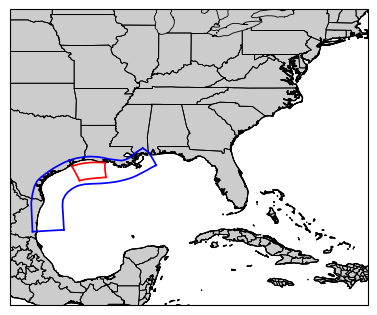

In [6]:
crs = ccrs.PlateCarree(central_longitude=-93.5)

fig, ax = plt.subplots(1, figsize = (1.83*2,1.52*2),dpi = 100, subplot_kw={'projection': crs}, constrained_layout = True)

ax.plot(ds_parent.lon_rho[-1,:], ds_parent.lat_rho[-1,:], 'b', lw=1.25,transform = cartopy.crs.PlateCarree())
ax.plot(ds_parent.lon_rho[0,:], ds_parent.lat_rho[0,:], 'b', lw=1.25,transform = cartopy.crs.PlateCarree())
ax.plot(ds_parent.lon_rho[:,0], ds_parent.lat_rho[:,0], 'b', lw=1.25,transform = cartopy.crs.PlateCarree())
ax.plot(ds_parent.lon_rho[:,-1], ds_parent.lat_rho[:,-1], 'b', lw=1.25,transform = cartopy.crs.PlateCarree())

ax.plot(ds_child.lon_rho[0,:], ds_child.lat_rho[0,:], 'r', lw=1.25,transform = cartopy.crs.PlateCarree())
ax.plot(ds_child.lon_rho[:,0], ds_child.lat_rho[:,0], 'r', lw=1.25,transform = cartopy.crs.PlateCarree(),)
ax.plot(ds_child.lon_rho[:,-1], ds_child.lat_rho[:,-1], 'r', lw=1.25,transform = cartopy.crs.PlateCarree(),)
ax.plot(ds_child.lon_rho[-1,:], ds_child.lat_rho[-1,:], 'r', lw=1.25,transform = cartopy.crs.PlateCarree(),)

ax.set_extent([-100, -70, 16, 44], ccrs.PlateCarree())
ax.add_feature(land_10m, facecolor='0.8', linewidth = 0.8)
ax.coastlines(resolution='10m', linewidth = 0.8)  
states_coastline(ax, resolution='10m', linewidth=0.6, color='black')
ax.set_aspect('auto')

# plt.savefig('figures/gom_zoomed_out.jpg', dpi = 300)  

Text(-90.5, 30.5, 'Mississippi River')

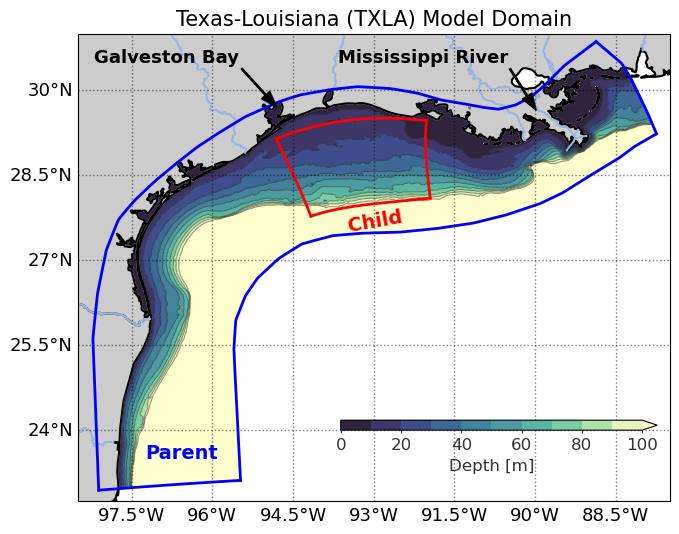

In [7]:
plt.rcParams.update({'font.size': 13})
hlevs = np.arange(10,110,10)  # isobath contour depths

crs = ccrs.PlateCarree()

fig,ax = plt.subplots(1, figsize = (6,5),dpi = 100, subplot_kw={'projection': crs}, constrained_layout = True)

mappable = ax.contourf(ds_parent.lon_rho,
                       ds_parent.lat_rho,
                       ds_parent.h, 
                       cmap = cmo.deep_r,
                       levels = [0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100],
                       extend = 'max',
                       transform = ccrs.PlateCarree())

ax.contour(ds_parent.lon_rho.values, 
           ds_parent.lat_rho.values, 
           ds_parent.h, hlevs, 
           colors='0.15', 
           transform=ccrs.PlateCarree(), 
           linewidths=.75, alpha = 0.5)

ax.set_extent([-98.5, -87.5, 22.75, 31], ccrs.PlateCarree())
ax.plot(ds_parent.lon_rho[-1,:], ds_parent.lat_rho[-1,:], 'b', lw=2,transform = cartopy.crs.PlateCarree())
ax.plot(ds_parent.lon_rho[0,:], ds_parent.lat_rho[0,:], 'b', lw=2,transform = cartopy.crs.PlateCarree())
ax.plot(ds_parent.lon_rho[:,0], ds_parent.lat_rho[:,0], 'b', lw=2,transform = cartopy.crs.PlateCarree())
ax.plot(ds_parent.lon_rho[:,-1], ds_parent.lat_rho[:,-1], 'b', lw=2,transform = cartopy.crs.PlateCarree())

ax.plot(ds_child.lon_rho[0,:], ds_child.lat_rho[0,:], 'r', lw=2,transform = cartopy.crs.PlateCarree())
ax.plot(ds_child.lon_rho[:,0], ds_child.lat_rho[:,0], 'r', lw=2,transform = cartopy.crs.PlateCarree(),)
ax.plot(ds_child.lon_rho[:,-1], ds_child.lat_rho[:,-1], 'r', lw=2,transform = cartopy.crs.PlateCarree(),)
ax.plot(ds_child.lon_rho[-1,:], ds_child.lat_rho[-1,:], 'r', lw=2,transform = cartopy.crs.PlateCarree(),)
    
cax = fig.add_axes([0.445, 0.15, 0.5275, 0.02]) 
cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')
cb.set_label(r'Depth [m]', fontsize=12, color='0.2')
cb.ax.tick_params(labelsize=12, length=2, color='0.2', labelcolor='0.2')
cb.set_ticks([0, 20, 40, 60, 80, 100])

gl = ax.gridlines(linewidth=1, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
ax.add_feature(land_10m, facecolor='0.8', linewidth = 1.5)
ax.coastlines(resolution='10m', linewidth = 1.5)  
# ax.add_feature(states_provinces, linewidth=1.5)
ax.add_feature(cfeature.BORDERS, linewidth=1.5)
ax.add_feature(cartopy.feature.RIVERS, linewidth=1.5)
ax.set_aspect('auto')

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

ax.set_title('Texas-Louisiana (TXLA) Model Domain', fontsize = 15)
ax.annotate('Child', xy = (-93.5, 27.52), color = 'r', rotation = 10, fontsize = 14, fontweight='bold')
ax.annotate('Parent', xy = (-97.25, 23.5), color = 'b', fontsize = 14, fontweight='bold')
ax.annotate('Galveston Bay', xy = (-94.8, 29.7), xytext = (-95.5, 30.5),
            arrowprops = dict(facecolor = 'black', width = 1, headwidth = 8,),
            color = 'k', fontsize = 13, horizontalalignment='right',  fontweight='bold')
ax.annotate('Mississippi River', xytext = (-90.5, 30.5), xy = (-89.98, 29.65),
            arrowprops = dict(facecolor = 'black', width = 1, headwidth = 8),
            color = 'k', fontsize = 13, horizontalalignment='right', fontweight='bold')

# plt.savefig('figures/txla/domain_overview.jpg', dpi = 1200)  

# Surface snapshots of vertical relative vorticity, divergence, strain, and salinity gradient magnitude at the surface 

NameError: name 'glob' is not defined

In [4]:
def surface_vorticity(ds, grid):
    '''
Calculates the surface vertical vorticity normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
rvort_psi: Normalized vorticity on the psi points 

    '''
    u = ds.u.isel(s_rho=-1)
    v = ds.v.isel(s_rho=-1)

    dudy = grid.derivative(u, 'Y')
    dvdx = grid.derivative(v, 'X')
    f_psi = xroms.to_psi(ds.f, grid)

    rvort_psi = (dvdx-dudy)/f_psi
    
    return rvort_psi 

def surface_divergence(ds, grid):
    '''
Calculates the surface divergence normalized by the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
divergence: Normalized divergence on the rho points 

    '''
    u = ds.u.isel(s_rho=-1)
    v = ds.v.isel(s_rho=-1)

    dudx = grid.derivative(u, 'X', boundary = 'extend')
    dvdy = grid.derivative(v, 'Y', boundary = 'extend')

    divergence = (dudx+dvdy)/ds.f 
    
    return divergence 

def surface_strain(ds, grid):
    '''
Calculates the surface strain normalized by the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
strain: Normalized strain on the psi points 

    '''
    u = ds.u.isel(s_rho=-1)
    v = ds.v.isel(s_rho=-1)

    dudx = grid.derivative(u, 'X', boundary = 'extend')
    dudx_psi = xroms.to_psi(dudx, grid)
    dvdy = grid.derivative(v, 'Y', boundary = 'extend')
    dvdy_psi = xroms.to_psi(dvdy, grid)
    
    dudy = grid.derivative(u, 'Y')
    dvdx = grid.derivative(v, 'X')
    
    f_psi = xroms.to_psi(ds.f, grid)
    strain = (((dudx_psi-dvdy_psi)**2+(dvdx+dudy)**2)**(1/2))/f_psi
    
    return strain

def surface_saltgradmag(ds, grid):
    '''
Calculates the surface horizontal salinity gradient magnitude normalized by 
the Coriolis frequency. 
----
Inputs:
ds - Xarray Dataset
grid - XGCM grid object 
----
Outputs:
sgradmag: horizontal salinity gradient magnitude on the psi points

    '''
    s = ds.salt.isel(s_rho=-1)

    dsdx = grid.derivative(s, 'X', boundary = 'extend')
    dsdx_psi = xroms.to_psi(dsdx, grid)
    dsdy = grid.derivative(s, 'Y', boundary = 'extend')
    dsdy_psi = xroms.to_psi(dsdy, grid)
    
    sgradmag = (dsdx_psi**2+dsdy_psi**2)**(1/2)
    
    return sgradmag

model_time = datetime(2010,6,20,12,30)

rvort = surface_vorticity(ds_avg, grid_avg).sel(ocean_time = model_time).load()
divergence = surface_divergence(ds_avg, grid_avg).sel(ocean_time = model_time).load()
strain_psi = surface_strain(ds_avg, grid_avg).sel(ocean_time = model_time).load()
sgradmag = surface_saltgradmag(ds_avg, grid_avg).sel(ocean_time = model_time).load()

rvort_child = surface_vorticity(ds_avg_child, grid_avg_child).sel(ocean_time = model_time).load()
divergence_child = surface_divergence(ds_avg_child, grid_avg_child).sel(ocean_time = model_time).load()
strain_psi_child = surface_strain(ds_avg_child, grid_avg_child).sel(ocean_time = model_time).load()
sgradmag_child = surface_saltgradmag(ds_avg_child, grid_avg_child).sel(ocean_time = model_time).load()

sss_parent = ds_avg.salt.isel(s_rho = -1).sel(ocean_time = model_time).load()
sss_child = ds_avg_child.salt.isel(s_rho = -1).sel(ocean_time = model_time).load() 

NameError: name 'ds_avg' is not defined

In [ ]:
plt.rcParams.update({'font.size': 11})
ncols = 2 ; nrows = 5
crs = ccrs.PlateCarree(central_longitude=-93.5)

fig,ax = plt.subplots(nrows,ncols,figsize=(8,12),dpi = 100, subplot_kw={'projection': crs}, constrained_layout = True)

mappable = ax[0,0].pcolormesh(ds_avg.lon_rho,
                            ds_avg.lat_rho,
                            sss_parent, 
                            cmap = cmo.haline,
                            vmin = 10,
                            vmax = 35,
                            transform = ccrs.PlateCarree())

mappable1 = ax[0,1].pcolormesh(ds_avg_child.lon_rho,
                            ds_avg_child.lat_rho,
                            sss_child, 
                            cmap = cmo.haline,
                            vmin = 10,
                            vmax = 35,
                            transform = ccrs.PlateCarree())
#Colorbar for first row
cb = fig.colorbar(mappable1, ax = ax[0,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.02)
cb.set_label(r'Salinity [g kg$^{-1}$]')

mappable2 = ax[1,0].pcolormesh(ds_avg.lon_psi,
                            ds_avg.lat_psi,
                            np.log10(sgradmag), 
                            cmap = cmo.thermal,
                            vmin = -6,
                            vmax = -2,
                            transform = ccrs.PlateCarree())
mappable3 = ax[1,1].pcolormesh(ds_avg_child.lon_psi,
                            ds_avg_child.lat_psi,
                            np.log10(sgradmag_child), 
                            cmap = cmo.thermal,
                            vmin = -6,
                            vmax = -2,
                            transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable3, ax = ax[1,1], orientation = 'vertical',  
                  ticks = [-6, -5, -4, -3, -2], format=tick.FormatStrFormatter('$10^{%d}$'),
                  extend = 'both', pad = 0.02)
cb.set_label(r'$|\nabla_H s|$ [g kg$^{-1}$ m$^{-1}$]')

mappable4 = ax[2,0].pcolormesh(ds_avg.lon_psi,
                             ds_avg.lat_psi,
                             rvort, 
                             cmap = cmo.curl,
                             vmin = -2,
                             vmax = 2,
                             transform = ccrs.PlateCarree())
mappable5 = ax[2,1].pcolormesh(ds_avg_child.lon_psi,
                             ds_avg_child.lat_psi,
                             rvort_child, 
                             cmap = cmo.curl,
                             vmin = -2,
                             vmax = 2,
                             transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable5, ax = ax[2,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.02)
cb.set_label(r'$\zeta/f$')

mappable6 = ax[3,0].pcolormesh(ds_avg.lon_rho,
                            ds_avg.lat_rho,
                            divergence, 
                            cmap = cmo.balance,
                            vmin = -2,
                            vmax = 2,
                            transform = ccrs.PlateCarree())
mappable7 = ax[3,1].pcolormesh(ds_avg_child.lon_rho,
                            ds_avg_child.lat_rho,
                            divergence_child, 
                            cmap = cmo.balance,
                            vmin = -2,
                            vmax = 2,
                            transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable7, ax = ax[3,1], orientation = 'vertical', 
                  extend = 'both', pad = 0.02)
cb.set_label(r'$\delta/f$')

mappable8 = ax[4,0].pcolormesh(ds_avg.lon_psi,
                             ds_avg.lat_psi,
                             strain_psi, 
                             cmap = cmo.amp,
                             vmin = 0,
                             vmax = 3,
                             transform = ccrs.PlateCarree())
mappable9 = ax[4,1].pcolormesh(ds_avg_child.lon_psi,
                             ds_avg_child.lat_psi,
                             strain_psi_child, 
                             cmap = cmo.amp,
                             vmin = 0,
                             vmax = 3,
                             transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable9, ax = ax[4,1], orientation = 'vertical', 
                  extend = 'max', pad = 0.02)
cb.set_label(r'$\alpha/f$')

for i in range(nrows):
    for j in range(ncols):
        ax[i,j].set_extent([-95, -91.6, 27.6, 30.1], ccrs.PlateCarree())
        ax[i,j].add_feature(land_10m, facecolor='0.8')
        ax[i,j].coastlines(resolution='10m', linewidth = 1.5)  
        ax[i,j].set_aspect('auto')
        ax[i,j].plot(ds_avg_child.lon_rho[0,:], 
                     ds_avg_child.lat_rho[0,:], 
                     'k', lw=2,transform = ccrs.PlateCarree())
        ax[i,j].plot(ds_avg_child.lon_rho[:,0], 
                     ds_avg_child.lat_rho[:,0], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
        ax[i,j].plot(ds_avg_child.lon_rho[:,-1], 
                     ds_avg_child.lat_rho[:,-1], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
        ax[i,j].plot(ds_avg_child.lon_rho[-1,:], 
                     ds_avg_child.lat_rho[-1,:], 
                     'k', lw=2,transform = ccrs.PlateCarree(),)
for i in range(nrows-1):
    gl = ax[i,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=False)
    gl = ax[i,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.left_labels = True
    gl.top_labels = False
    gl.bottom_labels = False

gl = ax[4,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = True
gl.top_labels = False
gl.bottom_labels = True

gl = ax[4,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.left_labels = False
gl.top_labels = False
gl.bottom_labels = True

ax[0,0].set_title('Coarse')
ax[0,1].set_title('Fine')

# Add in subplot labels 
ax[0,0].annotate('(a)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[0,1].annotate('(b)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[1,0].annotate('(c)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[1,1].annotate('(d)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[2,0].annotate('(e)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[2,1].annotate('(f)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[3,0].annotate('(g)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[3,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[3,1].annotate('(h)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[3,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[4,0].annotate('(i)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[4,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[4,1].annotate('(j)', xy = (-94.97, 29.9), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[4,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
fig.canvas.draw()

plt.savefig('/d2/home/dylan/JAMES/figures/draft1/surface_comparison.jpg', dpi = 300, bbox_inches='tight')